In [5]:
%run ./read_file.ipynb

In [6]:
from graphframes import GraphFrame

In [7]:
#filter to 3 malicious hosts

In [8]:
# df_first_events = get_firsts(df).cache()

In [9]:
# df_first_events.count()

In [10]:
# x is the number of hours
# y is the maximum number of events for any hour in a graph
# x_axis = 2*(x-1)+2
# y_axis = 2*(y-1)+2

In [11]:
# df_first_events.write.option("maxRecordsPerFile", 300000).mode("overwrite").parquet(f"{s3_url_trusted}/prod/graph/first_events")

In [12]:
df = readFirstEvents().cache()

 4:32PM UTC on Mar 25, 2023 --- read time: 4.6053149700164795 seconds ---


In [13]:
df.groupBy('malicious').count().show()

+---------+-------+
|malicious|  count|
+---------+-------+
|        1|   8596|
|        0|4587096|
+---------+-------+



In [14]:
df.limit(2).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,id,timestamp,objectID,actorID,object,action,hostname,user_name,privileges,image_path,...,file_path,direction,logon_id,requesting_domain,requesting_user,event_minute,event_day,event_hour,malicious,relationship
0,a6d975ba-5668-461b-bf1d-9eb73e4b9aec,2019-09-23 19:07:50.151,8b0a8788-d3bf-4a28-bfec-263be98860b3,0017062c-d130-46d7-816b-097845177ee4,FILE,READ,SysClient0351.systemia.com,None,None,\Device\HarddiskVolume1\Program Files\WindowsA...,...,\Device\HarddiskVolume1\Users\bbateman\AppData...,None,None,None,None,7,23,19,0,0017062c-d130-46d7-816b-097845177ee4->8b0a8788...
1,42245fb4-1650-4671-a59f-4911ab5de377,2019-09-23 19:07:50.151,8b0a8788-d3bf-4a28-bfec-263be98860b3,0017062c-d130-46d7-816b-097845177ee4,FILE,MODIFY,SysClient0351.systemia.com,None,None,\Device\HarddiskVolume1\Program Files\WindowsA...,...,\Device\HarddiskVolume1\Users\bbateman\AppData...,None,None,None,None,7,23,19,0,0017062c-d130-46d7-816b-097845177ee4->8b0a8788...


In [15]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- objectID: string (nullable = true)
 |-- actorID: string (nullable = true)
 |-- object: string (nullable = true)
 |-- action: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- privileges: string (nullable = true)
 |-- image_path: string (nullable = true)
 |-- parent_image_path: string (nullable = true)
 |-- new_path: string (nullable = true)
 |-- file_path: string (nullable = true)
 |-- direction: string (nullable = true)
 |-- logon_id: string (nullable = true)
 |-- requesting_domain: string (nullable = true)
 |-- requesting_user: string (nullable = true)
 |-- event_minute: integer (nullable = true)
 |-- event_day: integer (nullable = true)
 |-- event_hour: integer (nullable = true)
 |-- malicious: integer (nullable = true)
 |-- relationship: string (nullable = true)



In [16]:
#how big is this dataset with just first events? And how does the relationship work? 
df.count()

4595692

In [17]:
#What days are represented? 
df.select('event_day').distinct().orderBy('event_day').show()

+---------+
|event_day|
+---------+
|       23|
|       24|
|       25|
+---------+



In [18]:
#how many hours? 
df.select('event_hour').distinct().orderBy('event_hour').show(25)
#I see all hours which means we likely filtered on 23 before we enmbarked on this journey. I think this might mean
#we have all the events. Exciting. 

+----------+
|event_hour|
+----------+
|         0|
|         1|
|         2|
|         3|
|         4|
|         5|
|         6|
|         7|
|         8|
|         9|
|        10|
|        11|
|        12|
|        13|
|        14|
|        15|
|        16|
|        17|
|        18|
|        19|
|        20|
|        21|
|        22|
|        23|
+----------+



In [19]:
df_benign = df.where(col('malicious') == 0)
df_benign.count()

4587096

In [20]:
df_benign_lim = df_benign.limit(500000)

In [21]:
df_mal = df.where(col('malicious') == 1)
df_mal.count()
#I'm not thrilled that the malicious count isn't even close to what was shown in the paper

8596

In [22]:
print("image paths: " + str(df.select("image_path").distinct().count()))
print("parent paths: " + str(df.select("parent_image_path").distinct().count()))

image paths: 252
parent paths: 226


In [23]:
# df = df.limit(1000).cache()

In [24]:
df.count()

4595692

In [21]:
# Create distinct vertices with source as actorid, destination as objectid
src_vertices = df_benign_lim.selectExpr('actorID as id').distinct()
dst_vertices = df_benign_lim.selectExpr('objectID as id').distinct()
vertices = src_vertices.union(dst_vertices).distinct()

# Create edges by using timestamp as an edge
edges = df_benign_lim.selectExpr('actorID as src', 'objectID as dst', 'timestamp', 'object', 'action', 'hostname', 'user_name', 'privileges', 'image_path',
                      'parent_image_path', 'new_path', 'file_path', 'direction', 'logon_id', 'requesting_domain', 'requesting_user', 'malicious')

# Create GraphFrame
g = GraphFrame(vertices, edges)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [22]:
# Create distinct vertices with source as actorid, destination as objectid for malicious
src_vertices = df_mal.selectExpr('actorID as id').distinct()
dst_vertices = df_mal.selectExpr('objectID as id').distinct()
vertices = src_vertices.union(dst_vertices).distinct()

# Create edges by using timestamp as an edge
edges = df_mal.selectExpr('actorID as src', 'objectID as dst', 'timestamp', 'object', 'action', 'hostname', 'user_name', 'privileges', 'image_path',
                      'parent_image_path', 'new_path', 'file_path', 'direction', 'logon_id', 'requesting_domain', 'requesting_user', 'malicious')

# Create GraphFrame
g = GraphFrame(vertices, edges)

In [23]:
# display the vertices
print("Vertices:")
g.vertices.limit(2).toPandas()

Vertices:


,id
0,b9955edc-eccc-4948-8c2f-4cc6608c1e27
1,d5846376-9596-4283-8505-8e6112abf1f2


In [24]:
# display the edges
print("Edges:")
g.edges.limit(2).toPandas()

Edges:


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,src,dst,timestamp,object,action,hostname,user_name,privileges,image_path,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious
0,054df7d9-801e-49d0-b8cd-4f20b42a4305,a829facc-8645-4084-a606-e66f8f07c58c,2019-09-24 15:09:59.426,SHELL,COMMAND,SysClient0501.systemia.com,None,None,\Device\HarddiskVolume1\Windows\System32\Windo...,None,None,None,None,None,None,None,1
1,266392d7-012e-479b-a43a-fd5190bf22ac,d831de20-4434-4791-8d07-aa27286766c7,2019-09-24 19:41:17.964,FILE,READ,SysClient0851.systemia.com,None,None,powershell.exe,None,None,\Device\HarddiskVolume1\Windows\Prefetch\POWER...,None,None,None,None,1


In [25]:
g.inDegrees.limit(2).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


,id,inDegree
0,3b37b7f2-8d76-484c-9b27-e9c9808ccb0f,1
1,5d2847ec-878c-4e52-93b3-61427344e69c,1


In [26]:
# find all paths of length 6 in the graph
# Handling null values in shorter length 
motifs2 = g.find("(a)-[e1]->(b); (b)-[e2]->(c)")
#motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d)")
motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d); (d)-[e4]->(e); (e)-[e5]->(f); (f)-[e6]->(g)")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


## Motif Analysis

In [27]:
g.unpersist()

# Create distinct vertices with source as actorid, destination as objectid
src_vertices = df_benign_lim.selectExpr('actorID as id').distinct()
dst_vertices = df_benign_lim.selectExpr('objectID as id').distinct()
vertices = src_vertices.union(dst_vertices).distinct()

# Create edges by using timestamp as an edge
edges = df_benign_lim.selectExpr('actorID as src', 'objectID as dst', 'timestamp', 'object', 'action', 'hostname', 'user_name', 'privileges', 'image_path',
                      'parent_image_path', 'new_path', 'file_path', 'direction', 'logon_id', 'requesting_domain', 'requesting_user', 'malicious')

# Create GraphFrame
g = GraphFrame(vertices, edges)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [28]:
# find all paths of length 6 in the graph
# Handling null values in shorter length 
motifs2 = g.find("(a)-[e1]->(b); (b)-[e2]->(c)")
#motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d)")
motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d); (d)-[e4]->(e); (e)-[e5]->(f); (f)-[e6]->(g)")

In [29]:
df_benign_lim.filter( col('actorID') == col('objectID')).count()

0

In [30]:
motifs2.count()

1810342

In [31]:
motifs6.count()

91566945

In [25]:
#g.unpersist()

# Create distinct vertices with source as actorid, destination as objectid for malicious
src_vertices = df_mal.selectExpr('actorID as id').distinct()
dst_vertices = df_mal.selectExpr('objectID as id').distinct()
vertices = src_vertices.union(dst_vertices).distinct()

# Create edges by using timestamp as an edge
edges = df_mal.selectExpr('actorID as src', 'objectID as dst', 'timestamp', 'object', 'action', 'hostname', 'user_name', 'privileges', 'image_path',
                      'parent_image_path', 'new_path', 'file_path', 'direction', 'logon_id', 'requesting_domain', 'requesting_user', 'malicious')

# Create GraphFrame
g = GraphFrame(vertices, edges)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [26]:
# find all paths of length 6 in the graph
# Handling null values in shorter length 
motifs2 = g.find("(a)-[e1]->(b); (b)-[e2]->(c)")
#motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d)")
motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d); (d)-[e4]->(e); (e)-[e5]->(f); (f)-[e6]->(g)")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [27]:
motifs2.count()

9083

In [28]:
motifs6.count()

10357

In [50]:
motifx = g.find("(a)-[e1]->(b); (b)-[e2]->(c)").filter("e1.timestamp != e2.timestamp")
motifx.count()

9083

In [51]:
motifsy = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d); (d)-[e4]->(e); (e)-[e5]->(f); (f)-[e6]->(g)").filter("e1.timestamp != e2.timestamp and e2.timestamp != e3.timestamp and e3.timestamp != e4.timestamp and e4.timestamp != e5.timestamp and e5.timestamp != e6.timestamp")
motifsy.count()

10357

In [52]:
motifz = g.find("(a)-[e1]->(b); (b)-[e2]->(c)").filter("e1.timestamp != e2.timestamp and e1.src != e2.dst")
motifz.count()

9073

In [53]:
g.unpersist()

# Create distinct vertices with source as actorid, destination as objectid for malicious
src_vertices = df_mal.selectExpr('objectID as id').distinct()
dst_vertices = df_mal.selectExpr('actorID as id').distinct()
vertices = src_vertices.union(dst_vertices).distinct()

# Create edges by using timestamp as an edge
edges = df_mal.selectExpr('objectID  as src', 'actorID as dst', 'timestamp', 'object', 'action', 'hostname', 'user_name', 'privileges', 'image_path',
                      'parent_image_path', 'new_path', 'file_path', 'direction', 'logon_id', 'requesting_domain', 'requesting_user', 'malicious')

# Create GraphFrame
l = GraphFrame(vertices, edges)

In [54]:
# find all paths of length 6 in the graph
# Handling null values in shorter length 
motifs2 = l.find("(a)-[e1]->(b); (b)-[e2]->(c)")
#motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d)")
motifs6 = l.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d); (d)-[e4]->(e); (e)-[e5]->(f); (f)-[e6]->(g)")


In [55]:
motifs2.count()

9083

In [56]:
motifs6.count()

10357

In [57]:
df_mal.limit(2).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,id,timestamp,objectID,actorID,object,action,hostname,user_name,privileges,image_path,...,file_path,direction,logon_id,requesting_domain,requesting_user,event_minute,event_day,event_hour,malicious,relationship
0,10dc20ca-0dee-4a74-8e3e-3d7192c9443e,2019-09-24 15:09:59.426,a829facc-8645-4084-a606-e66f8f07c58c,054df7d9-801e-49d0-b8cd-4f20b42a4305,SHELL,COMMAND,SysClient0501.systemia.com,None,None,\Device\HarddiskVolume1\Windows\System32\Windo...,...,None,None,None,None,None,9,24,15,1,054df7d9-801e-49d0-b8cd-4f20b42a4305->a829facc...
1,ba7cbb42-cd05-4908-8cdc-1e1cc6452ebb,2019-09-24 19:41:17.964,d831de20-4434-4791-8d07-aa27286766c7,266392d7-012e-479b-a43a-fd5190bf22ac,FILE,READ,SysClient0851.systemia.com,None,None,powershell.exe,...,\Device\HarddiskVolume1\Windows\Prefetch\POWER...,None,None,None,None,41,24,19,1,266392d7-012e-479b-a43a-fd5190bf22ac->d831de20...


In [58]:
result1 = df_mal.groupBy("ObjectID").count().orderBy("count", ascending=False)

result1.limit(2).toPandas()

,ObjectID,count
0,5f8a2b40-e660-456c-bde7-0a117452809e,9
1,3463e44f-6662-4b77-a5c8-3e1f28af3f7c,6


In [59]:
result2 = df_mal.where(df_mal.objectID == 'b3736e65-b300-4f92-9d15-2b0b59cb5d9d')
result2.toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,id,timestamp,objectID,actorID,object,action,hostname,user_name,privileges,image_path,...,file_path,direction,logon_id,requesting_domain,requesting_user,event_minute,event_day,event_hour,malicious,relationship
0,6ddbfe14-ec48-486a-affb-3e757a3de0be,2019-09-23 17:34:20.279,b3736e65-b300-4f92-9d15-2b0b59cb5d9d,3eea9071-9ceb-468a-ad89-9e3890833e52,FILE,CREATE,SysClient0660.systemia.com,None,None,powershell.exe,...,\Device\HarddiskVolume1\Windows\TEMP\__PSScrip...,None,None,None,None,34,23,17,1,3eea9071-9ceb-468a-ad89-9e3890833e52->b3736e65...
1,c87fc3a2-66f4-4156-8c0d-0cbf5c430c6e,2019-09-23 17:34:20.279,b3736e65-b300-4f92-9d15-2b0b59cb5d9d,3eea9071-9ceb-468a-ad89-9e3890833e52,FILE,CREATE,SysClient0660.systemia.com,None,None,powershell.exe,...,\Device\HarddiskVolume1\Windows\TEMP\__PSScrip...,None,None,None,None,34,23,17,1,3eea9071-9ceb-468a-ad89-9e3890833e52->b3736e65...
2,51eab365-a413-4fbd-a640-a7265885faeb,2019-09-23 17:34:20.279,b3736e65-b300-4f92-9d15-2b0b59cb5d9d,3eea9071-9ceb-468a-ad89-9e3890833e52,FILE,WRITE,SysClient0660.systemia.com,None,None,powershell.exe,...,\Device\HarddiskVolume1\Windows\TEMP\__PSScrip...,None,None,None,None,34,23,17,1,3eea9071-9ceb-468a-ad89-9e3890833e52->b3736e65...


In [60]:
from pyspark.sql.functions import col

result3 = l.edges.filter(col("src") == "3eea9071-9ceb-468a-ad89-9e3890833e52")
result3.toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,src,dst,timestamp,object,action,hostname,user_name,privileges,image_path,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious
0,3eea9071-9ceb-468a-ad89-9e3890833e52,4aec5900-4572-4d09-81e6-fbc227a7f58d,2019-09-23 17:34:17.240,PROCESS,CREATE,SysClient0660.systemia.com,None,None,powershell.exe,\Device\HarddiskVolume1\Windows\system32\wbem\...,None,None,None,None,None,None,1


In [61]:
from pyspark.sql.functions import col

result4 = l.edges.filter(col("src").isin("b3736e65-b300-4f92-9d15-2b0b59cb5d9d", "3eea9071-9ceb-468a-ad89-9e3890833e52","4aec5900-4572-4d09-81e6-fbc227a7f58d", "<other-src>"))
result4.limit(2).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,src,dst,timestamp,object,action,hostname,user_name,privileges,image_path,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious
0,b3736e65-b300-4f92-9d15-2b0b59cb5d9d,3eea9071-9ceb-468a-ad89-9e3890833e52,2019-09-23 17:34:20.279,FILE,CREATE,SysClient0660.systemia.com,None,None,powershell.exe,None,None,\Device\HarddiskVolume1\Windows\TEMP\__PSScrip...,None,None,None,None,1
1,b3736e65-b300-4f92-9d15-2b0b59cb5d9d,3eea9071-9ceb-468a-ad89-9e3890833e52,2019-09-23 17:34:20.279,FILE,CREATE,SysClient0660.systemia.com,None,None,powershell.exe,None,None,\Device\HarddiskVolume1\Windows\TEMP\__PSScrip...,None,None,None,None,1


In [62]:
from graphframes import GraphFrame

# Create vertices from distinct src and dst values
vertices = result4.selectExpr("src as id").distinct().union(result4.selectExpr("dst as id").distinct()).distinct()

# Create edges from the result4 DataFrame
edges = result4.selectExpr("src", "dst", "timestamp", "object", "action", "hostname", "user_name", "privileges", "image_path",
                           "parent_image_path", "new_path", "file_path", "direction", "logon_id", "requesting_domain",
                           "requesting_user", "malicious")

# Create GraphFrame
g = GraphFrame(vertices, edges)



# find all paths of length 6 in the graph
# Handling null values in shorter length 
motifs2 = g.find("(a)-[e1]->(b); (b)-[e2]->(c)")
#motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d)")
motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d); (d)-[e4]->(e); (e)-[e5]->(f); (f)-[e6]->(g)")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [63]:
motifs2.count()

5

In [64]:
motifs6.count()

5

In [65]:
g.vertices.limit(6).toPandas()

,id
0,b3736e65-b300-4f92-9d15-2b0b59cb5d9d
1,3eea9071-9ceb-468a-ad89-9e3890833e52
2,4aec5900-4572-4d09-81e6-fbc227a7f58d


In [66]:
g.edges.limit(2).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,src,dst,timestamp,object,action,hostname,user_name,privileges,image_path,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious
0,b3736e65-b300-4f92-9d15-2b0b59cb5d9d,3eea9071-9ceb-468a-ad89-9e3890833e52,2019-09-23 17:34:20.279,FILE,CREATE,SysClient0660.systemia.com,None,None,powershell.exe,None,None,\Device\HarddiskVolume1\Windows\TEMP\__PSScrip...,None,None,None,None,1
1,b3736e65-b300-4f92-9d15-2b0b59cb5d9d,3eea9071-9ceb-468a-ad89-9e3890833e52,2019-09-23 17:34:20.279,FILE,CREATE,SysClient0660.systemia.com,None,None,powershell.exe,None,None,\Device\HarddiskVolume1\Windows\TEMP\__PSScrip...,None,None,None,None,1


In [67]:
motifs2.limit(2).toPandas()

,a,e1,b,e2,c
0,"(b3736e65-b300-4f92-9d15-2b0b59cb5d9d,)","(b3736e65-b300-4f92-9d15-2b0b59cb5d9d, 3eea907...","(3eea9071-9ceb-468a-ad89-9e3890833e52,)","(3eea9071-9ceb-468a-ad89-9e3890833e52, 4aec590...","(4aec5900-4572-4d09-81e6-fbc227a7f58d,)"
1,"(b3736e65-b300-4f92-9d15-2b0b59cb5d9d,)","(b3736e65-b300-4f92-9d15-2b0b59cb5d9d, 3eea907...","(3eea9071-9ceb-468a-ad89-9e3890833e52,)","(3eea9071-9ceb-468a-ad89-9e3890833e52, 4aec590...","(4aec5900-4572-4d09-81e6-fbc227a7f58d,)"


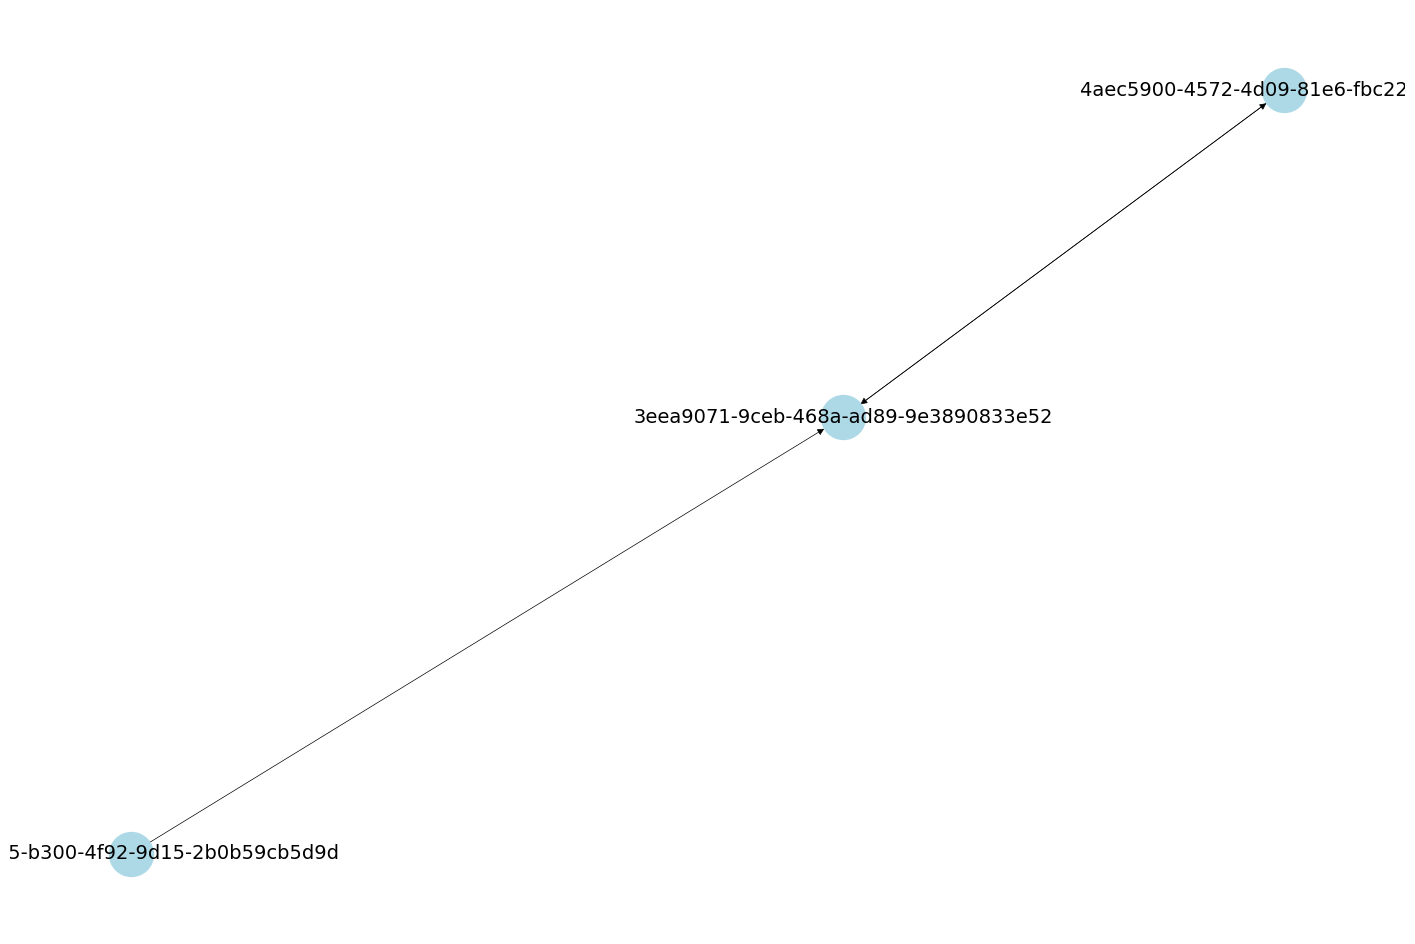

In [68]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert GraphFrame to NetworkX graph manually
edges = [(r['src'], r['dst']) for r in g.edges.select('src', 'dst').collect()]
nxg = nx.DiGraph(edges)

# Add vertex labels
labels = {r['id']: r['id'] for r in g.vertices.collect()}

# Draw the graph using NetworkX
fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(nxg, k=0.3, iterations=100)
nx.draw(nxg, pos, labels=labels, node_color='lightblue', node_size=1000, font_size=14, width=0.5)

# Adjust the figure size and font size
fig.set_size_inches(18, 12)
plt.rcParams.update({'font.size': 18})

# Show the graph using Matplotlib
plt.show()

In [ ]:
motifs6.limit(2).toPandas()

In [ ]:
from graphframes import *

# Define the vertices
vertices = spark.createDataFrame([
    ("A",),
    ("B",),
    ("C",)
], ["id"])

# Define the edges
edges = spark.createDataFrame([
    ("A", "B"),
    ("B", "B"),
    ("B", "C"),
    ("C", "B")
], ["src", "dst"])

# Create the GraphFrame
m = GraphFrame(vertices, edges)

In [ ]:
from graphframes import *
import networkx as nx

# Define the vertices
vertices = spark.createDataFrame([
    ("A",),
    ("B",),
    ("C",)
], ["id"])

# Define the edges
edges = spark.createDataFrame([
    ("A", "B"),
    ("B", "B"),
    ("B", "C"),
    ("C", "B")
], ["src", "dst"])

# Create the GraphFrame
m = GraphFrame(vertices, edges)

# Convert vertices and edges data frames to NetworkX graph object
v = vertices.toPandas()
e = edges.toPandas()
nxg = nx.DiGraph()
nxg.add_nodes_from(v["id"])
nxg.add_edges_from(zip(e["src"], e["dst"]))

# Draw the graph using NetworkX
pos = nx.spring_layout(nxg)
nx.draw_networkx(nxg, pos)

In [ ]:
# find all paths of length 6 in the graph
# Handling null values in shorter length 
motifs2 = m.find("(a)-[e1]->(b); (b)-[e2]->(c)")
#motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d)")
motifs6 = m.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d); (d)-[e4]->(e); (e)-[e5]->(f); (f)-[e6]->(g)")

In [ ]:
motifs2.toPandas()

In [ ]:
motifs6.toPandas()

In [ ]:
# filter paths to only those where all edges are connected
connected_paths_2 = motifs2.filter("e1.dst = e2.src")# and e2.dst = e3.src and e3.dst = e4.src and e4.dst = e5.src and e5.dst = e6.src")

connected_paths_2.count()

In [ ]:
# filter paths to only those where all edges are connected
connected_paths = motifs6.filter("e1.dst = e2.src and e2.dst = e3.src and e3.dst = e4.src and e4.dst = e5.src and e5.dst = e6.src")
connected_paths.count()
#interesting that motif of 6 returns so many more
#for everyone's awareness, this took a long long time with 500000 benign events, so long that I had to shut it down


In [ ]:
# get the 6 edges in each path and convert to a pandas dataframe
connected_paths.select("e1").limit(1).collect()

In [ ]:
type(connected_paths)

## DO NOT OVERWRITE /TEST_BIG. Please change the file path before saving again. 

In [ ]:
connected_paths.write.option("maxRecordsPerFile", 300000).mode("overwrite").parquet(f"{s3_url_trusted}/prod/graph/test_big")

In [ ]:
connected_paths = spark.read.parquet(f"{s3_url_trusted}/prod/graph/test").cache()

In [ ]:
connected_paths.limit(5).toPandas()

In [ ]:
#transpose values first by creating a trace column
# Add a new column "new_col" with ascending values starting at 1 before all other columns
df_transp = connected_paths.withColumn("Trace", (monotonically_increasing_id() + 1))
df_transp = df_transp.select("Trace", 
                             *[col for col in df_transp.columns if col != "Trace"])


In [ ]:
df_transp.limit(1).toPandas()

In [ ]:
#drop all vertices
df_transp = df_transp.drop('a','b','c','d','e','f','g')

In [ ]:
df_transp.printSchema()

In [ ]:
#transpose rows 
stacked_df = df_transp.selectExpr(
    "Trace", 
    "posexplode(array(e1, e2, e3, e4, e5, e6)) as (pos, col)"
).select(
    "Trace", 
    expr('''CASE pos 
    WHEN 0 THEN 'e1' 
    WHEN 1 THEN 'e2'
    WHEN 2 THEN 'e3'
    WHEN 3 THEN 'e4'
    WHEN 4 THEN 'e5'
    ELSE 'e6' END''').alias("event"),
    "col"
).orderBy("Trace","event")

stacked_df.limit(7).toPandas()

In [ ]:
#explode columns
stacked_df.printSchema()

In [ ]:
#explode columns
stacked_df = stacked_df.select(*stacked_df.columns, "col.*").drop('col')

In [ ]:
stacked_df.printSchema()

In [ ]:
stacked_df.limit(10).toPandas()
#TODO: we have a problem with graphframes, need to remove all traces that loop to themselves. 

In [ ]:
#lets do some onehot encoding. let's start with object. 

#create sparse vecotrs for child objects
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
#turn into numeric index before encoding
indexer = StringIndexer(inputCol='new_path', outputCol='np_numeric')
indexer_fitted = indexer.fit(stacked_df)
df_indexed = indexer_fitted.transform(stacked_df)

if len(indexer_fitted.labels) > 0:

    encoder = OneHotEncoder(inputCols=['np_numeric'], outputCols=['np_sparse'],dropLast=False)
    df_onehot_np = encoder.fit(df_indexed).transform(df_indexed)
    df_onehot_np = df_onehot_np.drop('np_numeric')
    print(indexer_fitted.labels)
    df_onehot_np.limit(1).show()
else:
    print('only none')



In [ ]:
def oneHotCol(df, colm, dict_mapping):
    
    #now action
    #turn into numeric index before encoding
    
    num = colm+'_numeric'
    sparse = colm+'_sparse'
    indexer = StringIndexer(inputCol=colm, outputCol=num, handleInvalid="keep")
    indexer_fitted = indexer.fit(df)
    df_indexed = indexer_fitted.transform(df)

    encoder = OneHotEncoder(inputCols=[num], outputCols=[sparse],dropLast=False)
    df_onehot = encoder.fit(df_indexed).transform(df_indexed)
    df_onehot = df_onehot.drop(colm, num)

    #set dict to mapping
    dict_mapping[colm] = indexer_fitted.labels
        
    return df_onehot, dict_mapping
    

In [ ]:
#use function to create object ohe
dict_mapping = {}
df_onehot, dict_mapping = oneHotCol(stacked_df,'object', dict_mapping)
print(dict_mapping['object'])
df_onehot.limit(1).toPandas()

In [ ]:
#now do it for all other columns
list_cols = ['object','action','user_name', 'privileges',
             'image_path','parent_image_path','new_path',
             'direction','logon_id','requesting_domain',
             'requesting_user','file_path']
df_onehot = stacked_df
for colm in list_cols:
    df_onehot, dict_mapping = oneHotCol(df_onehot,colm, dict_mapping)
    #print(dict_mapping[colm])
    print(colm)

print(dict_mapping.keys())
df_onehot.limit(1).toPandas()
    

In [ ]:
dict_mapping['file_path']

In [ ]:
#use new function to transpose and explode trace and then one hot all the columns you want. Return encoded df 
#and dropped columns. 
%run trace_encode.ipynb

In [ ]:
list_cols = ['object','action','user_name', 'privileges',
             'image_path','parent_image_path','new_path',
             'direction','logon_id','requesting_domain',
             'requesting_user']
df_test, dict_test = trace_encode(connected_paths,list_cols)

In [ ]:
print(dict_test.keys())
df_test.limit(1).toPandas()

In [ ]:
dict_test['image_path']

In [ ]:
#so this is pretty fast for malicious connected, what about benign


In [ ]:
# using split and applying in ml with pypark
train, test, val = connected_paths.randomSplit([0.80, 0.15, 0.05], seed=12345)

In [ ]:
val.count()

In [ ]:
# create new dataframe to union and create duplicate rows
df_dup = df.withColumn('id', lit(None).cast(StringType()))

In [ ]:
df_dup.limit(5).toPandas()

In [ ]:
df_new = df.union(df_dup).sort("timestamp").cache()
df.unpersist()

In [ ]:
df_new.limit(5).toPandas()

In [ ]:
# len(df_new.select('relationship').distinct().collect())

In [ ]:
tot = df_new.count()

In [ ]:
df_ratios = df_new.groupBy("object") \
              .count() \
              .withColumnRenamed('count', 'cnt_per_group') \
              .withColumn('perc_of_count_total', (col('cnt_per_group') / tot) * 100 ) \
              .cache()

In [ ]:
df_ratios.limit(5).toPandas()

In [ ]:
df_new.limit(5).toPandas()

In [ ]:
connected_paths.write.option("maxRecordsPerFile", 300000).mode("overwrite").parquet(f"{s3_url_trusted}/prod/graph/test")

In [ ]:
stacked_df.limit(10).toPandas()

In [ ]:
# Reference: https://stackoverflow.com/questions/36725353/applying-a-window-function-to-calculate-differences-in-pyspark

from pyspark.sql import Window
from pyspark.sql.functions import lag, col, coalesce, lit

# Define the window specification
window_spec = Window.partitionBy("Trace").orderBy("timestamp")

# Calculate the timestamp difference between the current event and the preceding event
stacked_df = stacked_df.withColumn(
    "timestamp_difference",
    coalesce(
        (col("timestamp").cast("long") - lag(col("timestamp").cast("long")).over(window_spec)) * 1000
        + (col("timestamp").cast("double") % 1 - lag(col("timestamp").cast("double")).over(window_spec) % 1) * 1000,
        lit(None).cast("double")
    )
)

stacked_df.limit(10).toPandas()


In [ ]:
# filter rows where 'Trace' equals 642 to test code
filtered_df = stacked_df.filter(stacked_df.Trace == 642)
filtered_df.toPandas()

In [ ]:
# Check above code

from datetime import datetime

timestamp1 = "2019-09-23 17:34:20.279"
timestamp2 = "2019-09-23 17:43:13.564"

# Convert the string timestamps to datetime objects
dt1 = datetime.strptime(timestamp1, "%Y-%m-%d %H:%M:%S.%f")
dt2 = datetime.strptime(timestamp2, "%Y-%m-%d %H:%M:%S.%f")

# Calculate the time difference
time_difference = dt2 - dt1

# Convert the time difference to milliseconds
time_difference_ms = time_difference.total_seconds() * 1000

print("Time difference (in milliseconds):", time_difference_ms)

In [ ]:
# Above code in function format

from pyspark.sql import Window
from pyspark.sql.functions import lag, col, coalesce, lit

def calculate_timestamp_difference(stacked_df):
    # Define the window specification
    window_spec = Window.partitionBy("Trace").orderBy("timestamp")

    # Calculate the timestamp difference between the current event and the preceding event
    result_df = stacked_df.withColumn(
        "timestamp_difference",
        coalesce(
            (col("timestamp").cast("long") - lag(col("timestamp").cast("long")).over(window_spec)) * 1000
            + (col("timestamp").cast("double") % 1 - lag(col("timestamp").cast("double")).over(window_spec) % 1) * 1000,
            lit(None).cast("double")
        )
    )

    return result_df

# Usage example
result_df = calculate_timestamp_difference(stacked_df)
result_df.limit(10).toPandas()


In [ ]:
# Reference for Bucketizer: https://stackoverflow.com/questions/46225587/how-to-bin-in-pyspark
# Leveraged ChatGPT 4 to create bin edges to feed into Bucketizer

from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import col, when
from pyspark.sql import functions as F

# if timestamp_bins exists then drop the column
stacked_df = stacked_df.drop("timestamp_bins")

# calculate the min and max values of the timestamp_difference column
min_max = stacked_df.agg(F.min("timestamp_difference").alias("min"), F.max("timestamp_difference").alias("max")).collect()
min_val = min_max[0]["min"]
max_val = min_max[0]["max"]

# calculate the bin width
bin_width = (max_val - min_val) / 10

# create the bin edges by starting from negative infinity to capture
# the smallest values. Subsequently, add that to the minimum value to
# create a list of the ending points for each group. It starts from the 
# minimum value (min_val) and adds the size of each group (bin_width) 
# multiplied by a number i from 1 to 10.
bins = [float('-inf')] + [min_val + i * bin_width for i in range(1, 11)]

# print the bins
bin_ranges = [f"{lower:.2f} - {upper:.2f}" for lower, upper in zip(bins[:-1], bins[1:])]
print("Bins:", bin_ranges)

# create a Bucketizer instance
bucketizer = Bucketizer(splits=bins, inputCol="timestamp_difference", outputCol="timestamp_bins")

# transform the DataFrame
stacked_df = bucketizer.transform(stacked_df)

# increment the bin index by 1 to start from bin 1 instead of 0,
# code was initially putting timestamp differences of 0 in bin 0,
# thus code is needed to correctly bin these items to bin 1
stacked_df = stacked_df.withColumn("timestamp_bins", F.col("timestamp_bins") + 1)


stacked_df.limit(10).toPandas()

In [ ]:
# show records in bin 9 for testing

bin_9_records = stacked_df.filter(stacked_df.timestamp_bins == 9)

# Show the result
bin_9_records.limit(10).toPandas()

In [ ]:
# histogram to show bin distribution

import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = stacked_df.select("timestamp_bins").toPandas()

# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(pandas_df["timestamp_bins"], bins=10, edgecolor="black")
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Histogram of Timestamp Bins")
plt.show()


## Code to test Motifs

In [ ]:
from graphframes import GraphFrame

# Define the vertices (nodes)
vertices = spark.createDataFrame([
    ("A", "Node A"),
    ("B", "Node B"),
    ("C", "Node C"),
    ("D", "Node D"),
    ("E", "Node E"),
    ("F", "Node F")
], ["id", "name"])

# Define the edges (connections)
edges = spark.createDataFrame([
    ("A", "B"),
    ("B", "C"),
    ("C", "D"),
    ("D", "E"),
    ("E", "F")
], ["src", "dst"])

# Create a GraphFrame
g = GraphFrame(vertices, edges)

# Find all paths of length 6 in the graph
motifs2 = g.find("(a)-[e1]->(b); (b)-[e2]->(c)")
motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d); (d)-[e4]->(e); (e)-[e5]->(f)")


In [ ]:
# Print the results
motifs2.toPandas()


In [ ]:
motifs6.toPandas()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = ['A', 'B1', 'B2', 'C1', 'C2', 'D1', 'D2']
G.add_nodes_from(nodes)

# Add edges
edges = [
    ('A', 'B1'),
    ('A', 'B2'),
    ('B1', 'C1'),
    ('B1', 'C2'),
    ('B2', 'C1'),
    ('B2', 'C2'),
    ('C1', 'D1'),
    ('C1', 'D2'),
    ('C2', 'D1'),
    ('C2', 'D2'),
]
G.add_edges_from(edges)

# Define a hierarchical layout
pos = {
    'A': (0, 3),
    'B1': (-1, 2),
    'B2': (1, 2),
    'C1': (-1, 1),
    'C2': (1, 1),
    'D1': (0, 0),
    'D2': (2, 0),
}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=16, font_weight='bold', arrowsize=30)
plt.show()




In [ ]:
# Find all paths of length 6 in the graph

from graphframes import GraphFrame
from pyspark.sql.functions import col

# Create the vertices DataFrame
vertices = spark.createDataFrame([
    ('A',),
    ('B1',),
    ('B2',),
    ('C1',),
    ('C2',),
    ('D1',),
    ('D2',)
], ['id'])

# Create the edges DataFrame
edges = spark.createDataFrame([
    ('A', 'B1'),
    ('A', 'B2'),
    ('B1', 'C1'),
    ('B1', 'C2'),
    ('B2', 'C1'),
    ('B2', 'C2'),
    ('C1', 'D1'),
    ('C1', 'D2'),
    ('C2', 'D1'),
    ('C2', 'D2')
], ['src', 'dst'])

# Create the GraphFrame
g = GraphFrame(vertices, edges)

# Show the vertices and edges
print("Vertices:")
g.vertices.show()
print("Edges:")
g.edges.show()

# Find all the paths of length 3
paths = g.find("(a)-[]->(b); (b)-[]->(c)")
paths.show()

motifs2 = g.find("(a)-[e1]->(b); (b)-[e2]->(c)")
motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d)")


In [ ]:
# Print the results
motifs2.toPandas()

In [ ]:
# Print the results
motifs6.toPandas()